([<matplotlib.axis.XTick at 0x1b81622c88>,
 <a list of 7 Text xticklabel objects>)

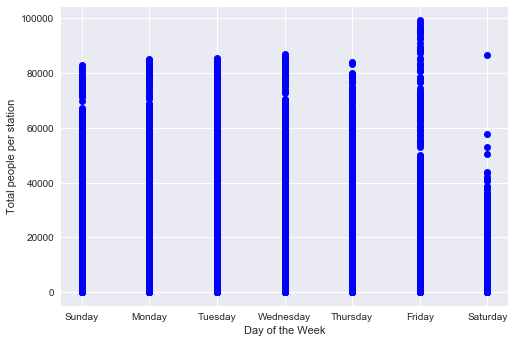

In [582]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import pickle
import datetime
from datetime import datetime as dt
import dateutil.parser
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn")

## IMPORT PICKLED FILE

def get_data(week_nums):

    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)


filename = 'bensonMTA.pkl'  # make sure this file is in the same directory as your jupyter notebook
try:
    with open(filename, 'rb') as pklfile:
        df = pickle.load(pklfile)
except:
    week_nums = [160604, 160611, 160618, 160625, 160702, 160709, 160716, 160723,
                 160730, 160806, 160813, 160820, 160827, 170603, 170610, 170617,
                 170624, 170701, 170708, 170715, 170722, 170729, 170805, 170812,
                 170819, 170826, 180602, 180609, 180616, 180623, 180630]
    df = get_data(week_nums)
    with open(filename, 'wb') as pklfile:
        df = pickle.dump(df, pklfile)


## CREATE DATETIME SPECIFIC ROWS

df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

df['time_hour'] = df.DATE_TIME.dt.hour

df['WEEKDAY'] = df['DATE_TIME'].dt.weekday

## STRIP COLUMNS OF LEADING WHITESPACE

df.rename(columns={column: column.strip() for column in df.columns}, inplace=True)

## SORT DATAFRAME TO GET CONSECUTIVE ENTRIES/EXITS PER TURNSTILE

df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=True)

df['real_entries'] = df['ENTRIES'].diff()
df['real_exits'] = df['EXITS'].diff()

turnstiles_df = df.copy()

df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"]).head()

turnstiles_df['totals'] = turnstiles_df['real_entries'] + turnstiles_df['real_exits']

(turnstiles_df.groupby(["STATION", "DATE_TIME"])).sum(
).sort_values("totals", ascending=False).head(50)

## EDIT DATAFRAME TO INCLUDE SUM OF TOTALS PER STATION AT EACH DATETIME (4 HOUR PERIOD)

turnstiles_df = turnstiles_df.groupby(["STATION", "DATE_TIME"]).sum(
).sort_values("totals", ascending=False).reset_index()

turnstiles_df['time_hour'] = turnstiles_df['DATE_TIME'].dt.hour

turnstiles_df['WEEKDAY'] = turnstiles_df['DATE_TIME'].dt.weekday

turnstiles_df['STATION'].head(50).unique()

## REMOVE ERRORS

turnstiles_df.loc[(turnstiles_df['totals'] < 0) | (
    turnstiles_df['totals'] > 100000), 'totals'] = np.nan
turnstiles_df['totals'] = turnstiles_df['totals'].interpolate(method="linear")

x = [0, 1, 2, 3, 4, 5, 6]
weeklabels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.plot(turnstiles_df.WEEKDAY, turnstiles_df.totals, 'bo')
plt.xlabel("Day of the Week")
plt.ylabel('Total people per station')
plt.xticks(x, weeklabels)

[('14 ST-UNION SQ', 24126.5), ('34 ST-HERALD SQ', 23159.0), ('TIMES SQ-42 ST', 20980.0), ('FLUSHING-MAIN', 16435.0), ('59 ST COLUMBUS', 16174.0), ('34 ST-PENN STA', 15058.0), ('59 ST', 14820.0), ('GRD CNTRL-42 ST', 12607.0), ('JKSN HT-ROOSVLT', 12489.0), ('W 4 ST-WASH SQ', 11861.0), ('50 ST', 11076.0), ('42 ST-PORT AUTH', 10350.0), ('ATL AV-BARCLAY', 10158.0), ('145 ST', 9613.5), ('CHAMBERS ST', 9359.0), ('8 AV', 9082.0), ('125 ST', 8990.0), ('23 ST', 8566.0), ('BEDFORD AV', 8346.0), ('47-50 STS ROCK', 8279.0), ('7 AV', 8204.5), ('86 ST', 8069.0), ('103 ST', 7553.0), ('116 ST', 7528.0), ('42 ST-BRYANT PK', 7428.0), ('JAMAICA CENTER', 7392.0), ('DELANCEY/ESSEX', 6915.0), ('1 AV', 6887.5), ("B'WAY-LAFAYETTE", 6729.5), ('GRAND ST', 6611.5), ('72 ST-2 AVE', 6563.0), ('JAY ST-METROTEC', 6549.0), ('86 ST-2 AVE', 6464.0), ('49 ST', 6392.0), ('SUTPHIN-ARCHER', 6012.0), ('CROWN HTS-UTICA', 5761.5), ('BOWLING GREEN', 5622.0), ('82 ST-JACKSON H', 5508.0), ('FOREST HILLS 71', 5499.5), ('NOSTRAND A

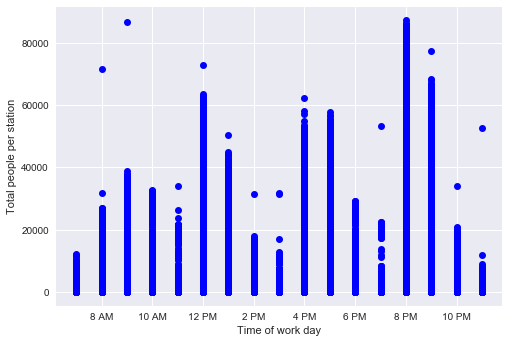

In [583]:
daytime_df = turnstiles_df[turnstiles_df['time_hour'] > 6]
y = [8, 10, 12, 14, 16, 18, 20, 22]
timelabels = ['8 AM', '10 AM', '12 PM', '2 PM', '4 PM', '6 PM', '8 PM', '10 PM']
plt.plot(daytime_df.time_hour, daytime_df.totals, 'bo')
plt.xlabel('Time of work day')
plt.ylabel('Total people per station')
plt.xticks(y, timelabels)

eight_pm_df = turnstiles_df[turnstiles_df['time_hour'] == 20]

new_df = turnstiles_df.groupby(['STATION'])['real_entries', 'real_exits'].median()

totals = {}
for index, row in new_df.iterrows():
    totals[index] = row['real_entries'] + row['real_exits']

sorted_totals = sorted(totals.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_totals)

In [584]:
new_df = eight_pm_df.groupby(['STATION'])['real_entries', 'real_exits'].median()

eight_totals = {}
for index, row in new_df.iterrows():
    eight_totals[index] = row['real_entries'] + row['real_exits']

eight_sorted_totals = sorted(eight_totals.items(), key=operator.itemgetter(1), reverse=True)
print(eight_sorted_totals)

[('34 ST-HERALD SQ', 75462.0), ('34 ST-PENN STA', 71010.0), ('TIMES SQ-42 ST', 62494.0), ('GRD CNTRL-42 ST', 44397.0), ('23 ST', 42063.5), ('47-50 STS ROCK', 41853.0), ('59 ST COLUMBUS', 38911.0), ('59 ST', 37528.0), ('86 ST', 34716.0), ('CHAMBERS ST', 34674.0), ('42 ST-BRYANT PK', 31122.0), ('FLUSHING-MAIN', 29207.5), ('50 ST', 28638.0), ('LEXINGTON AV/53', 25864.0), ('ATL AV-BARCLAY', 25023.0), ('42 ST-PORT AUTH', 24921.0), ('JKSN HT-ROOSVLT', 23115.0), ('14 ST', 22358.0), ('JAY ST-METROTEC', 20545.0), ('BOWLING GREEN', 20500.0), ('125 ST', 18639.0), ('BEDFORD AV', 18575.0), ('JAMAICA CENTER', 18368.0), ('WALL ST', 18202.0), ('BOROUGH HALL', 18079.0), ('145 ST', 16984.0), ('49 ST', 16611.5), ('GRAND ST', 15912.0), ('SPRING ST', 14329.0), ('51 ST', 14148.0), ('CHURCH AV', 13451.0), ('CANAL ST', 12710.0), ('1 AV', 12469.0), ('168 ST', 12250.0), ('CROWN HTS-UTICA', 11620.0), ('SUTPHIN-ARCHER', 11532.0), ('JUNCTION BLVD', 10926.0), ('PRINCE ST', 10779.0), ('KINGS HWY', 10528.0), ('BROOKL